# LSTM Model Prediction on Bitcoin using Tashman Method

## Import Libraries

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## Defining Classes and Functions

In [2]:
# Defining Classes and Functions
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

class LSTM(torch.nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 = torch.nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = torch.nn.Linear(128, num_classes) # fully connected last layer
        self.relu = torch.nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
    
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))
            
def plot_big_picture_time_series_predictions(true, preds, train_test_cutoff):
    plt.figure(figsize=(10,6)) # plotting
    plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
    plt.plot(true[::-1], label='Actual Data') # actual plot
    plt.plot(preds[::-1], label='Predicted Data') # predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.show()
    
def plot_small_picture_predicted_days(test_target, test_predict):
    plt.plot(test_target, label="Actual Data")
    plt.plot(test_predict, label="LSTM Predictions")
    plt.title('Actual Data vs. LSTM Predictions')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show();

## Reading in, Viewing, and Refactoring the Dataset

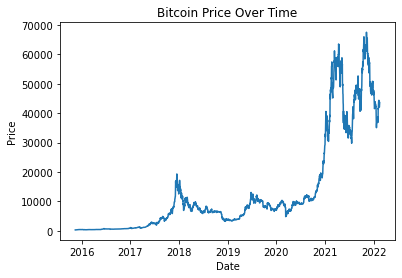

In [3]:
# Reading in, Viewing, and Refactoring Dataset
df = pd.read_csv(r'../Datasets/BitcoinData.csv', index_col='Date', parse_dates=True) #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
# print(df)
# print(df.dtypes)
cleanData = df

repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9', }
cleanData['Vol.'] = cleanData['Vol.'].replace(repl_dict, regex=True).map(pd.eval).astype(float)

cleanData['Price'] = cleanData['Price'].astype(str).str.replace(',', '').astype(float)
cleanData['Open'] = cleanData['Open'].astype(str).str.replace(',', '').astype(float)
cleanData['High'] = cleanData['High'].astype(str).str.replace(',', '').astype(float)
cleanData['Low'] = cleanData['Low'].astype(str).str.replace(',', '').astype(float)
cleanData['Change %'] = cleanData['Change %'].astype(str).str.replace('%', '').astype(float)
# print(cleanData.describe())
# print(cleanData.info())
# print(cleanData.head())

plt.plot(cleanData.Price)
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Preparing the Dataset

In [4]:
# Create X and y datasets
X, y = cleanData.drop(columns=['Price']), cleanData.Price.values
print(X.shape, y.shape)

(2285, 5) (2285,)


### Training/Testing Parameters

In [5]:
# We want to predict data several months or so in the future, here we will set the training data size at 85%
# and the remaining 15% can be used for testing data
train_test_percentage = 0.85
test_test_percentage = 0.70
total_samples = len(X)
train_test_cutoff = round(train_test_percentage * total_samples) # TRAIN/TEST split cutoff!!!!!!!!!
test_samples = total_samples - train_test_cutoff
train_test_size = round(test_test_percentage * test_samples)
test_test_size = test_samples - train_test_size
print(f'Train Samples: {train_test_cutoff}')
print(f'Test Samples: {test_samples}')
print(f'Test-Train Samples: {train_test_size}')
print(f'Test-Test Samples: {test_test_size}')

Train Samples: 1942
Test Samples: 343
Test-Train Samples: 240
Test-Test Samples: 103


In [6]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

X_ss, y_mm = split_sequences(X_trans, y_trans, train_test_size, test_test_size)
print(X_ss.shape, y_mm.shape)

print('These should be the same....')
print(y_mm[0])
print(y_trans[(train_test_size-1):(test_samples-1)].squeeze(1))

assert y_mm[0].all() == y_trans[train_test_size:test_samples-1].squeeze(1).all()

print(f'Train size: {train_test_cutoff} Test Size: {test_samples}')

X_train = X_ss[:(-1*test_samples)]
X_test = X_ss[(-1*test_samples):]

y_train = y_mm[:(-1*test_samples)]
y_test = y_mm[(-1*test_samples):]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

# HERE IS WHERE TASHMAN WILL BE CONDUCTED
print(f'Current test training set size {train_test_size}')
print(f'Current test testing set size {test_test_size}')
tashman_split = .33
percentage_push = .25
start_limit = round(tashman_split*train_test_size)
print(f'The first training set is from 0 to {start_limit}')
second_start_limit = round(percentage_push*train_test_size)
print(f'The second training set is from {second_start_limit} to {2*start_limit}')
print(f'The third training set is from {2*second_start_limit} to {train_test_size}')

# X_test_1 = X_test[:,:start_limit,:]
# print(X_test_1.shape)
# X_test_2 = X_test[:,second_start_limit:2*start_limit,:]
# print(X_test_2.shape)
# X_test_3 = X_test[:,2*second_start_limit:train_test_size,:]
# print(X_test_3.shape)

# Now we need to convert our test and training sets into tensors, which are like numpy arrays but are used
# in pytorch
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# Here we will use the LSTM NN for our prediction algorithm. The input shape of the data depends on whether
# batch_first is true or not. Here, we will set it to be true, meaning the size of the input is (N, L, Hin),
# where N is the batch size, L is the sequence length, and Hin is the input size (number of features). In other
# words, we want the dimensions to be the rows of the dataframe in the first dimension, followed by the length of
# the dataframe in the second dimension, and finally the features (in which we have 5) in the final dimension.
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], X_train_tensors.shape[1], 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], X_test_tensors.shape[1], 
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

# Lastly, we want to check the data logic of the test set. We want to predict 50 timesteps into the future with 
# Bitcoin. Based on split_sequence() above, we simply need to add the last sample of 100 days to X_test, run the 
# model on it, and compare these predictions with the last 50 days of y_test, these correspond to a period of 100
# days in X_test's last sample, proceeded immediately by the next 50 days in the last sample of y_test
# HERE, we want to check that the last 50 samples that we will be predicting match the last 50 values of y 
# in the test set
X_check, y_check = split_sequences(X, y.reshape(-1, 1), train_test_size, test_test_size)
X_check[-1][0:4]

print(X.iloc[(-1*(test_samples-1)):(-1*(test_samples-4))])

print('These should be the same....')
print(y_check[-1])
print(cleanData.Price.values[(-1*test_test_size):])

(1944, 240, 5) (1944, 103)
These should be the same....
[0.4668102  0.52489347 0.52366747 0.52717883 0.56143841 0.56566394
 0.59274458 0.59829878 0.57588409 0.52298454 0.55046689 0.54056961
 0.55072876 0.4919685  0.49487133 0.52816082 0.52376567 0.54357361
 0.57833014 0.55405562 0.54113798 0.55022883 0.52574155 0.50984818
 0.52588587 0.56687358 0.57925113 0.56629331 0.57183263 0.51126314
 0.55245617 0.55021098 0.60109299 0.54162749 0.63352993 0.64311178
 0.68603817 0.6902399  0.73682496 0.73481336 0.73004624 0.83883149
 0.82623225 0.8617833  0.87073727 0.84837614 0.83451222 0.84992501
 0.79487698 0.84588546 0.83746414 0.85536762 0.85407615 0.79218841
 0.81124201 0.81414483 0.79902813 0.72378828 0.74053123 0.75622374
 0.76494114 0.79604793 0.83566978 0.82321486 0.83156178 0.88861843
 0.90852309 0.93584475 0.93233934 0.94067882 0.88596854 0.8876781
 0.88425154 0.86000381 0.85938932 0.82771714 0.85818266 0.87301816
 0.86121196 0.84425029 0.87277862 0.86892505 0.86960054 0.86971362
 0.8525

## Training Model

### LSTM Parameters

In [7]:
# Time to instantiate an instance of our LSTM model
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = test_test_size # number of output classes (Amount of data we are predicting outwards)

# Set up the 3 training periods
lstm_first_class = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm_second_class = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm_third_class = LSTM(num_classes, input_size, hidden_size, num_layers)

# Here we will use MSE (Mean Squared Error) as our loss function, this can be changed to an absolute error to be
# in accordance with Tashman method
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser_1 = torch.optim.Adam(lstm_first_class.parameters(), lr=learning_rate)
optimiser_2 = torch.optim.Adam(lstm_second_class.parameters(), lr=learning_rate)
optimiser_3 = torch.optim.Adam(lstm_third_class.parameters(), lr=learning_rate)

In [8]:
# Train here
# Training lstm_first_class
print('First tashman split training')
training_loop(n_epochs=n_epochs,
              lstm=lstm_first_class,
              optimiser=optimiser_1,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final[:,:start_limit,:],
              y_test=y_test_tensors)
print('Second tashman split training')
training_loop(n_epochs=n_epochs,
              lstm=lstm_second_class,
              optimiser=optimiser_2,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final[:,second_start_limit:2*start_limit,:],
              y_test=y_test_tensors)
print('Third tashman split training')
training_loop(n_epochs=n_epochs,
              lstm=lstm_third_class,
              optimiser=optimiser_3,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final[:,2*second_start_limit:train_test_size,:],
              y_test=y_test_tensors)

First tashman split training
Epoch: 0, train loss: 0.08505, test loss: 0.02344
Epoch: 100, train loss: 0.00644, test loss: 0.00599
Epoch: 200, train loss: 0.00520, test loss: 0.00052
Epoch: 300, train loss: 0.00476, test loss: 0.00025
Epoch: 400, train loss: 0.00276, test loss: 0.00022
Epoch: 500, train loss: 0.00247, test loss: 0.00026
Epoch: 600, train loss: 0.00213, test loss: 0.00028
Epoch: 700, train loss: 0.00195, test loss: 0.00029
Epoch: 800, train loss: 0.00178, test loss: 0.00028
Epoch: 900, train loss: 0.00170, test loss: 0.00025
Second tashman split training
Epoch: 0, train loss: 0.07725, test loss: 0.02691
Epoch: 100, train loss: 0.01698, test loss: 0.00819
Epoch: 200, train loss: 0.00767, test loss: 0.00183
Epoch: 300, train loss: 0.00538, test loss: 0.00017
Epoch: 400, train loss: 0.00494, test loss: 0.00005
Epoch: 500, train loss: 0.00477, test loss: 0.00004
Epoch: 600, train loss: 0.00467, test loss: 0.00004
Epoch: 700, train loss: 0.00433, test loss: 0.00004
Epoch: 80

## Predictions and Graphs

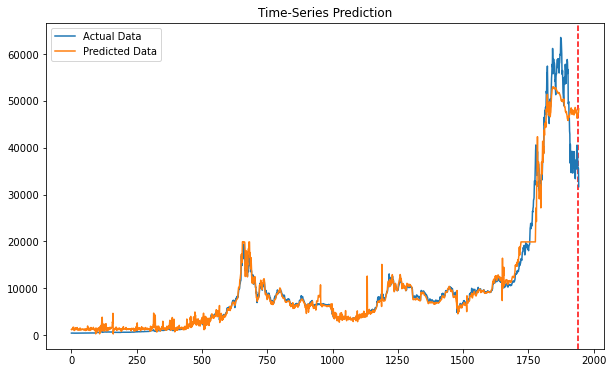

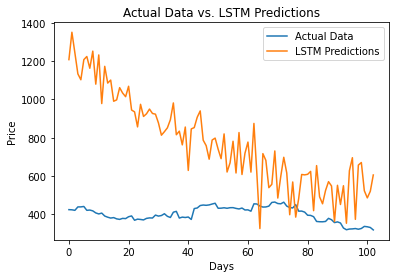

In [9]:
# Predictions
df_X_ss = ss.transform(cleanData.drop(columns=['Price'])) # old transformers
df_y_mm = mm.transform(cleanData.Price.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, train_test_size, test_test_size)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], df_X_ss.shape[1], df_X_ss.shape[2]))

train_predict = lstm_first_class(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
# Plotting the first graph
plot_big_picture_time_series_predictions(true, preds, train_test_cutoff)
    
test_predict = lstm_first_class(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

# Plotting the second graph
plot_small_picture_predicted_days(test_target, test_predict)

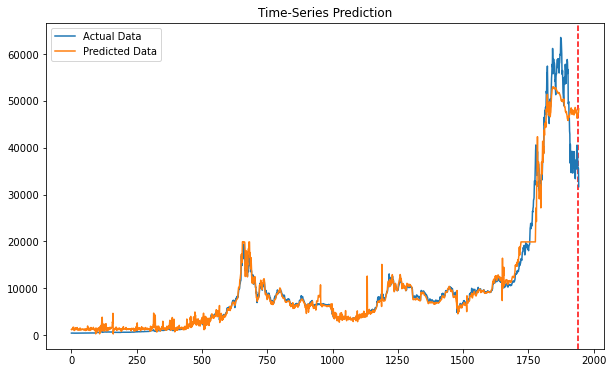

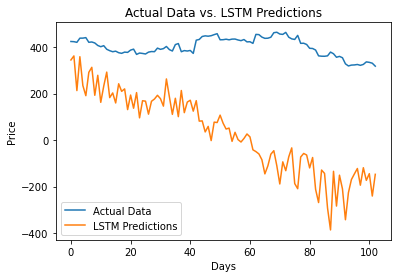

In [10]:
# Predictions
df_X_ss = ss.transform(cleanData.drop(columns=['Price'])) # old transformers
df_y_mm = mm.transform(cleanData.Price.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, train_test_size, test_test_size)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], df_X_ss.shape[1], df_X_ss.shape[2]))

train_predict = lstm_first_class(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
# Plotting the first graph
plot_big_picture_time_series_predictions(true, preds, train_test_cutoff)
    
test_predict = lstm_second_class(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

# Plotting the second graph
plot_small_picture_predicted_days(test_target, test_predict)

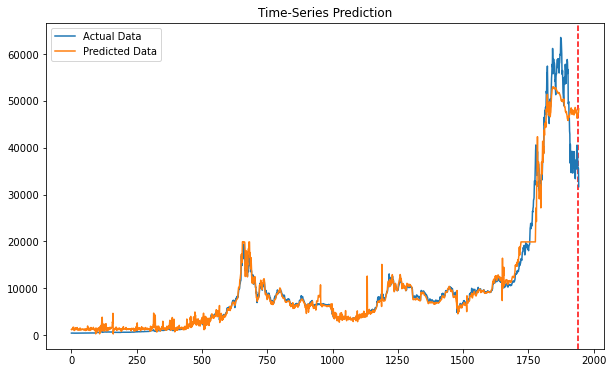

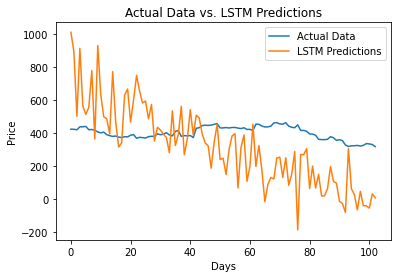

In [11]:
# Predictions
df_X_ss = ss.transform(cleanData.drop(columns=['Price'])) # old transformers
df_y_mm = mm.transform(cleanData.Price.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, train_test_size, test_test_size)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], df_X_ss.shape[1], df_X_ss.shape[2]))

train_predict = lstm_first_class(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
# Plotting the first graph
plot_big_picture_time_series_predictions(true, preds, train_test_cutoff)
    
test_predict = lstm_third_class(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

# Plotting the second graph
plot_small_picture_predicted_days(test_target, test_predict)